In [149]:
import numpy as np
import math

Goes over how to create a singular attention head and the math behind it.

In [150]:
# L is going to be the length of the input sequence
# Input sequence in this case is:
#   My name is Grant
L, d_k, d_v = 4, 8, 8
q = np.random.randn(L, d_k) # Query vector
k = np.random.randn(L, d_k) # Key vector
v = np.random.randn(L, d_v) # Value vector

In [151]:
print("Q\n", q)
print("K\n", k)
print("V\n", v)

Q
 [[-1.8216576   1.57630301 -0.20778506 -0.76956296  0.8582931  -0.19293435
   1.36478309 -1.16379581]
 [ 0.19526426 -1.1455688   0.82022973 -0.12065462  0.59703497  1.36787102
   1.1080685   1.0466633 ]
 [-0.39615992  0.45472356  0.3731153  -0.917862   -0.25715102  0.31966482
   0.65316773  1.23238473]
 [ 0.97518666  1.0072593   1.37378508  1.35722793  0.12906707 -1.46900382
  -0.2785378  -0.66744096]]
K
 [[ 1.27808408  0.10814351 -0.71982338  0.42554257 -0.9594835   0.88881091
  -0.73726105  0.68289195]
 [ 1.05186207  1.77090363 -1.71466956 -0.47977787  0.68470112 -0.94408477
  -0.89386628  0.36465941]
 [ 0.32049713 -0.51142799  0.07883858 -0.43990039 -1.52478932 -0.88887919
   0.80722071 -2.00635035]
 [ 1.36305392  0.85382501 -0.9313731   1.1714878   0.6679662   0.41030909
  -0.29642096  1.89337655]]
V
 [[ 0.82470654  1.01832051 -0.0742799  -1.0382902   1.47397322  1.17119684
  -0.93415327  0.85873486]
 [ 2.66896272 -0.04549671  1.40019354  0.44697015 -0.79854277  0.04474527
  -0.6

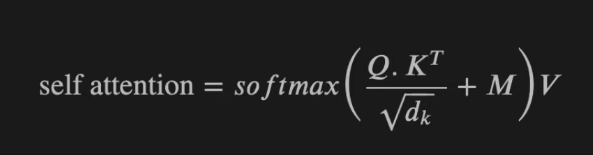

In [152]:
# Self attention matrix mulitplication
# Tells us how much we are going to pay attention to each word in the vector
np.matmul(q, k.T)

array([[-5.13162632,  0.72634813,  1.23159053, -3.95904473],
       [ 0.02466978, -4.66322154, -2.5655427 ,  0.9960772 ],
       [-0.22543252, -0.42313976, -1.76373004,  0.52464226],
       [-0.73596461,  1.28358903,  1.53191185,  0.80203887]])

In [153]:
# Shows why we need the srt(dk) - to minimize variance
q.var(), k.var(), np.matmul(q, k.T).var()

(0.8486781117897737, 1.0044257532182868, 4.539987409148102)

In [154]:
# Shows the minimized veector
scaled = np.matmul(q,k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(0.8486781117897737, 1.0044257532182868, 0.5674984261435128)

In [155]:
# Masking - makes sure that we dont look at future words when we are evaluating the current word in the decoder
#   - not required in the encoder because all of our inputs are passed into the transformer simultaneously
mask = np.tril(np.ones((L,L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [156]:
# Transforms the mask
mask[mask == 0] = -np.infty
mask[mask == 1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [157]:
scaled += mask
scaled

array([[-1.81430389,        -inf,        -inf,        -inf],
       [ 0.00872209, -1.64869779,        -inf,        -inf],
       [-0.07970243, -0.1496025 , -0.62357273,        -inf],
       [-0.26020278,  0.45381725,  0.54161263,  0.28356356]])

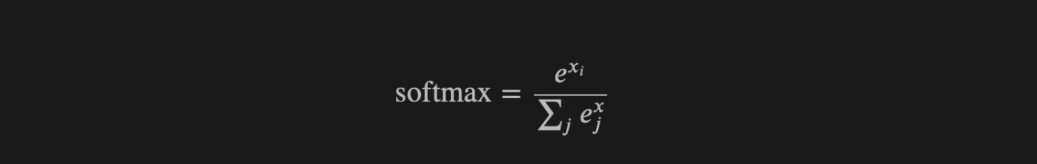

In [158]:
# Softmax is used to transform a vector into a probability distribution so that the values add up to one
#   reduces variance and makes it more readible and interpretable
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis = -1)).T

In [159]:
# Each row adds up to one because it is a probability distribution
#   makes seeing relationships between inputs much easier
attention = softmax(scaled)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.83989135, 0.16010865, 0.        , 0.        ],
       [0.39793326, 0.37106759, 0.23099914, 0.        ],
       [0.14297456, 0.29198042, 0.31877391, 0.24627112]])

In [160]:
# Multiplies the attention and value matrices
#   better encapsulates the context of the word
#   the later words are better contextualized which is what we want
new_v = np.matmul(attention, v)
print("New Values:\n", new_v)
print("Old Values:\n", v)

New Values:
 [[ 0.82470654  1.01832051 -0.0742799  -1.0382902   1.47397322  1.17119684
  -0.93415327  0.85873486]
 [ 1.11998792  0.84799417  0.16179606 -0.80048716  1.11012375  0.9908422
  -0.89393577  1.03681582]
 [ 1.17065721  0.36313586  0.71141608 -0.40727543  0.17234923  0.169297
  -0.69948529  1.20227442]
 [ 0.61078621 -0.06871078  0.59055451 -0.17979845 -0.60204035 -0.6348897
  -0.37527522  0.52623517]]
Old Values:
 [[ 0.82470654  1.01832051 -0.0742799  -1.0382902   1.47397322  1.17119684
  -0.93415327  0.85873486]
 [ 2.66896272 -0.04549671  1.40019354  0.44697015 -0.79854277  0.04474527
  -0.68296445  1.97098558]
 [-0.64020382 -0.10911464  0.95848003 -0.69247603 -0.51030663 -1.35656217
  -0.32177026  0.55925046]
 [-0.33430803 -0.67501889 -0.45962707  0.2391161  -1.69305168 -1.55507137
   0.24472677 -1.42243927]]
